Dans ce script, nous allons tester différents modèles de type convolutionnelsur le dataset 

résultat:
* l'utilisation des batchs rend l'inférence globale plus rapide
* un modèle a besoin de beaucoup de temps / parametres pour arriver à un certain niveau d'accuracy

In [1]:
import retinoto_py as fovea
args = fovea.Params()
args

Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	 user laurentperrinet	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 1998 has been set.


Params(image_size=224, do_mask=True, num_epochs=10, n_train_stop=0, seed=1998, batch_size=64, num_workers=4, model_name='resnet18', do_scratch=False, lr=0.02, delta1=0.1, delta2=0.001, weight_decay=0.001, shuffle=True, verbose=True)

# testing a ResNet model on the validation dataset

In [2]:
VAL_DATA_DIR = args.DATAROOT / 'Imagenet_full' / 'val'
val_loader, class_to_idx, idx_to_class = fovea.get_loader(args, VAL_DATA_DIR)
model = fovea.load_model(args)
model.eval()
print(f"Model {args.model_name} loaded.")

Model resnet18 loaded.


In [3]:

# # --- Parameter Counts ---
# param_stats = count_parameters(model)
# print("🔢 Parameter Count:")
# print(f"  Total:     {param_stats['total_parameters']:,}")
# print(f"  Trainable: {param_stats['trainable_parameters']:,}")
# print("-" * 50)

# # --- Layer Counts ---
# print("🧱 Layer Count:")
# # 1. Total number of nn.Module objects
# total_layers = count_layers(model)
# print(f"  Total Modules (nn.Module): {total_layers}")

# # 2. Counting specific layer types
# from torch import nn

# conv_layers = count_layers(model, layer_type=nn.Conv2d)
# linear_layers = count_layers(model, layer_type=nn.Linear)
# print(f"  Convolutional (nn.Conv2d): {conv_layers}")
# print(f"  Linear (nn.Linear): {linear_layers}")
# print("=" * 50)

# testing the role of batch_size on Wall Clock Time 

In [4]:
json_filename = args.data_cache / '12_batch_size.json'

# %rm {json_filename}

if json_filename.exists():
    results = fovea.pd.read_json(json_filename)
else:
    all_results = []
    for batch_size in [2, 4, 8, 16, 32, 64, 128, 256]:
        args = fovea.Params(batch_size=batch_size)
        model = fovea.load_model(args)
        tic = fovea.time.time()
        accuracy = fovea.get_validation_accuracy(args, model, val_loader)
        toc = fovea.time.time()
        this_result = {         
                        'batch_size': batch_size,
                        'accuracy': accuracy,
                        'wall_clock_time': toc-tic,
                        }
        all_results.append(this_result)
    results = fovea.pd.DataFrame(all_results)
    results.to_json(json_filename, orient='records', indent=2)

In [5]:
results.T

,0,1,2,3,4,5,6,7
batch_size,2.000000,4.000000,8.000000,16.000000,32.000000,64.000000,128.000000,256.000000
accuracy,0.478400,0.478880,0.478420,0.478980,0.480160,0.480020,0.478860,0.480060
wall_clock_time,236.743366,224.343533,225.649941,230.997538,238.076125,260.216289,252.924555,265.031637


In [6]:
%cat {json_filename}

[
  {
    "batch_size":2,
    "accuracy":0.4784,
    "wall_clock_time":236.743366003
  },
  {
    "batch_size":4,
    "accuracy":0.47888,
    "wall_clock_time":224.3435330391
  },
  {
    "batch_size":8,
    "accuracy":0.47842,
    "wall_clock_time":225.6499409676
  },
  {
    "batch_size":16,
    "accuracy":0.47898,
    "wall_clock_time":230.9975380898
  },
  {
    "batch_size":32,
    "accuracy":0.48016,
    "wall_clock_time":238.0761249065
  },
  {
    "batch_size":64,
    "accuracy":0.48002,
    "wall_clock_time":260.2162890434
  },
  {
    "batch_size":128,
    "accuracy":0.47886,
    "wall_clock_time":252.9245548248
  },
  {
    "batch_size":256,
    "accuracy":0.48006,
    "wall_clock_time":265.0316369534
  }
]

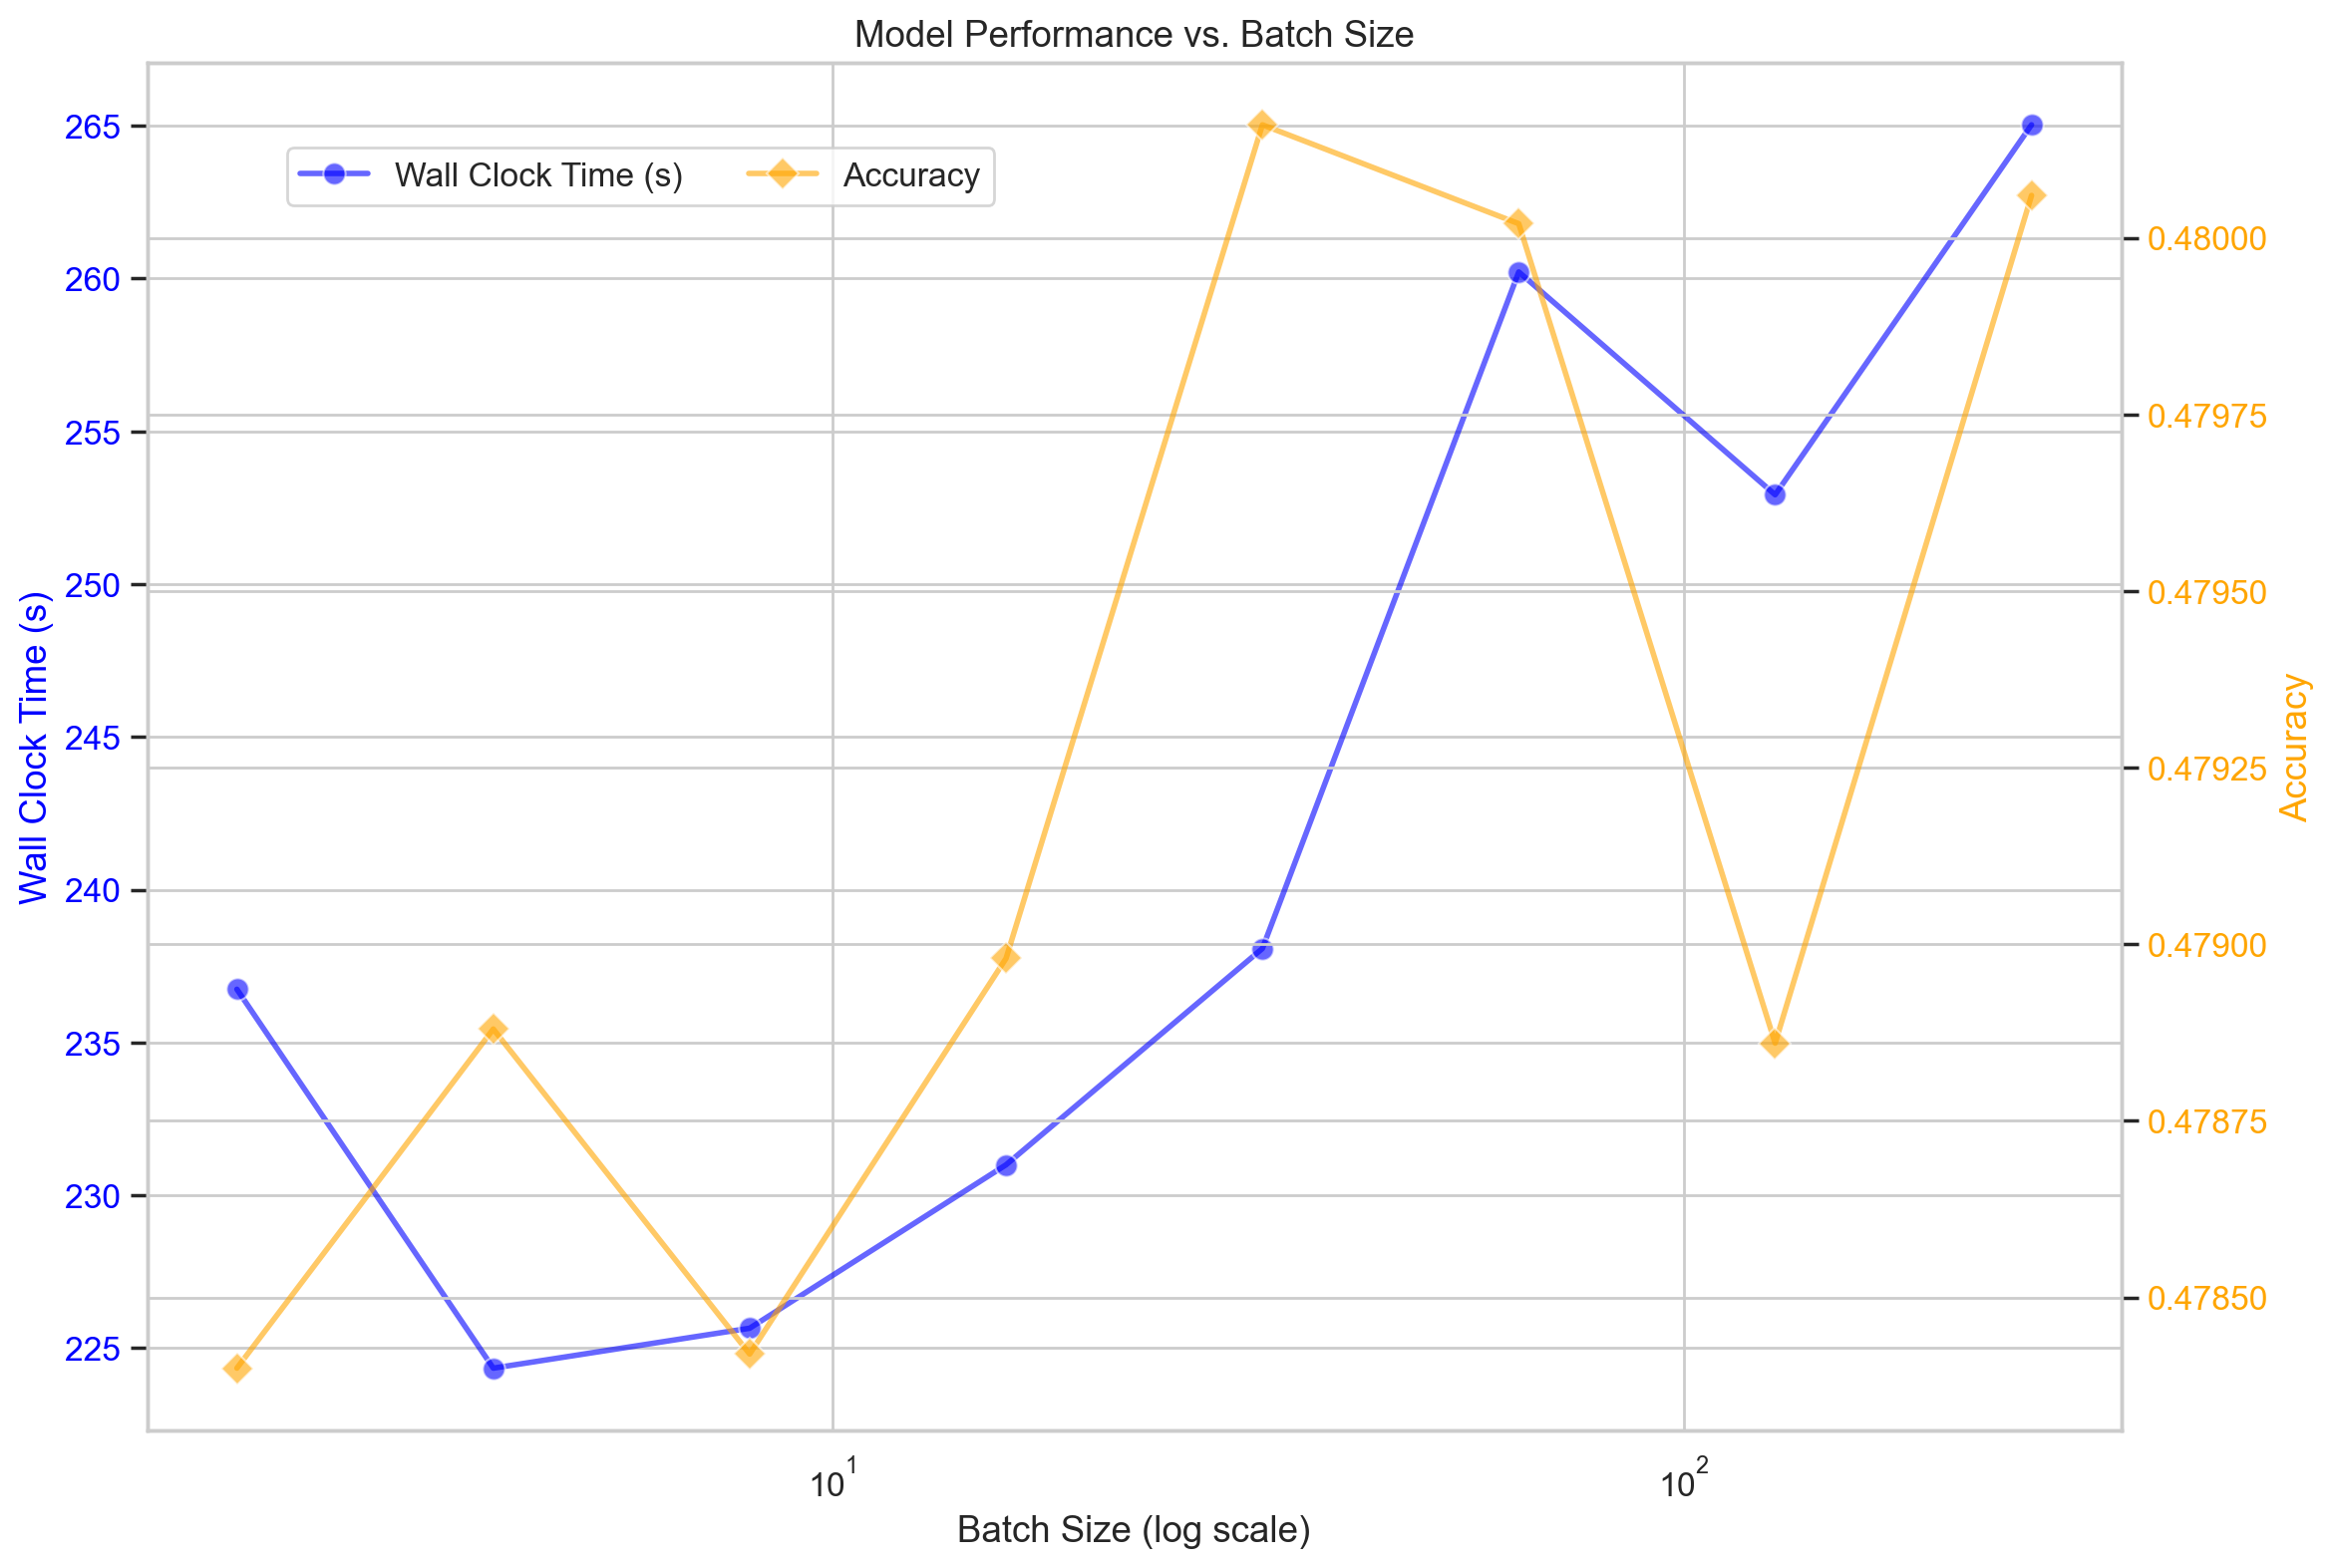

In [7]:
# --- Plot 1: Wall Clock Time (in Blue) ---
# Assign a label directly for legend creation
ax = fovea.sns.lineplot(
    data=results,
    x='batch_size',
    y='wall_clock_time',
    color='blue',                  # Set color to blue
    marker='o',
    markersize=8,
    alpha=0.6,
    lw=2,
    label='Wall Clock Time (s)',   # Legend label for this line
    legend=False
)

# --- Plot 2: Accuracy (in Orange) ---
ax2 = ax.twinx()
fovea.sns.lineplot(
    data=results,
    x='batch_size',
    y='accuracy',
    color='orange',                # Set color to orange
    marker='D',                    # Different marker for distinction
    markersize=8,
    alpha=0.6,
    lw=2,
    ax=ax2,                        # Plot on the secondary y-axis
    label='Accuracy',               # Legend label for this line
    legend=False
)

# --- Final Touches ---
# Set log scale for the x-axis
ax.set_xscale('log')

# Set axis labels and title
ax.set_xlabel('Batch Size (log scale)')
ax.set_ylabel('Wall Clock Time (s)', color='blue')
ax2.set_ylabel('Accuracy', color='orange')

# Match the tick colors to the lines for clarity
ax.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='orange')

# Set the main title
ax.set_title('Model Performance vs. Batch Size')

# Create a single, unified legend
# Get handles and labels from both axes
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
# Combine them and place the legend
ax.legend(h1 + h2, l1 + l2, loc='upper center', bbox_to_anchor=(0.25, 0.95), ncol=2)


# plt.tight_layout()
# Adjust layout to make space for the legend below the plot
fovea.plt.subplots_adjust(bottom=0.05) 
fovea.plt.show()

# testing the role of `num_workers` on Wall Clock Time 

In [8]:
args.num_workers

4

In [ ]:

json_filename = args.data_cache / '12_num_workers.json'

if json_filename.exists():
    results = fovea.pd.read_json(json_filename)
else:
    all_results = []
    for num_workers in [0, 1, 2, 4, 8, 16]:
        args = fovea.Params(num_workers=num_workers)
        model = fovea.load_model(args)
        tic = fovea.time.time()
        accuracy = fovea.get_validation_accuracy(args, model, val_loader)
        toc = fovea.time.time()
        this_result = {         
                        'num_workers': num_workers,
                        'accuracy': accuracy,
                        'wall_clock_time': toc-tic,
                        }
        all_results.append(this_result)
    results = fovea.pd.DataFrame(all_results)
    results.to_json(json_filename, orient='records', indent=2)

Evaluating resnet18:   0%|          | 0/782 [00:00<?, ?it/s]

In [ ]:
results.T

In [ ]:
# %rm {json_filename}

In [ ]:
# --- Plot 1: Wall Clock Time (in Blue) ---
# Assign a label directly for legend creation
ax = fovea.sns.lineplot(
    data=results,
    x='num_workers',
    y='wall_clock_time',
    color='blue',                  # Set color to blue
    marker='o',
    markersize=8,
    alpha=0.6,
    lw=2,
    label='Wall Clock Time (s)',   # Legend label for this line
    legend=False
)

# --- Plot 2: Accuracy (in Orange) ---
ax2 = ax.twinx()
fovea.sns.lineplot(
    data=results,
    x='num_workers',
    y='accuracy',
    color='orange',                # Set color to orange
    marker='D',                    # Different marker for distinction
    markersize=8,
    alpha=0.6,
    lw=2,
    ax=ax2,                        # Plot on the secondary y-axis
    label='Accuracy',               # Legend label for this line
    legend=False
)


# Set axis labels and title
ax.set_xlabel('Number of workers (num_workers)')
ax.set_ylabel('Wall Clock Time (s)', color='blue')
ax2.set_ylabel('Accuracy', color='orange')

# Match the tick colors to the lines for clarity
ax.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='orange')

# Set the main title
ax.set_title('Model Performance vs. num_workers')

# Create a single, unified legend
# Get handles and labels from both axes
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
# Combine them and place the legend
ax.legend(h1 + h2, l1 + l2, loc='upper center', bbox_to_anchor=(0.25, 0.95), ncol=2)


# plt.tight_layout()
# Adjust layout to make space for the legend below the plot
fovea.plt.subplots_adjust(bottom=0.05) 
fovea.plt.show()